In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import QGOpt as qgo

#### Here one generates a random Hamiltonian.

In [5]:
#=========================================#
ham_dim = 100 # dimension of a Hamiltonian
#=========================================#

# random Hamiltonian
Q = qgo.manifolds.real_to_complex(tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64))
Q, _ = tf.linalg.qr(Q)  # random unitary (QR based)

S = tf.random.uniform((ham_dim,), -3, 3)
S = tf.cast(S, dtype=tf.complex128)  # random spectrum

H = tf.einsum('ik,k,jk->ij', Q, S, tf.math.conj(Q))

# minimal eigenvalue of a Hamiltonian
min_value = tf.cast(tf.linalg.eigvalsh(H)[0],
                   dtype=tf.float64)

# initial density matrix
rho = tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64)
rho = qgo.manifolds.real_to_complex(rho)
rho = tf.linalg.adjoint(rho) @ rho
rho = rho / tf.linalg.trace(rho)
rho = qgo.manifolds.complex_to_real(rho)

#========= Positive cone manifold =============#
m_log = qgo.manifolds.PositiveCone('log')
m_chol = qgo.manifolds.PositiveCone('cholesky')
#==============================================#

#================================= optimizers================================#
opts = {
        'GD_log':qgo.optimizers.RSGD(m_log, 0.5),
        'GD_momentum_log':qgo.optimizers.RSGD(m_log, 0.5, 0.9),
        'Adam_log':qgo.optimizers.RAdam(m_log, 0.5),
        'Adam_with_ams_log':qgo.optimizers.RAdam(m_log, 0.5, ams=True),
        'GD_cholesky':qgo.optimizers.RSGD(m_chol, 0.5),
        'GD_momentum_cholesky':qgo.optimizers.RSGD(m_chol, 0.5, 0.9),
        'Adam_cholesky':qgo.optimizers.RAdam(m_chol, 0.5),
        'Adam_with_ams_cholesky':qgo.optimizers.RAdam(m_chol, 0.5, ams=True)
       }
#=============================================================================#

#### Optimization loop solves the folloving optimization problem $$\frac{{\rm Tr}(HS)}{{\rm Tr}(S)}\rightarrow \min_{S\in \mathbb{S}_{++}},$$ by using different types of Riemannian optimizers

In [6]:
#=============================================#
number_of_steps = 3000  # number of iterations
#=============================================#

err_dict = {} # the disct will be filed by lists of errors vs optimizer

# loop over optimizers
for key, opt in opts.items():

    err = []  # will be filled by error vs iter
    rho_var = tf.Variable(rho)  # turning initial density matrix to variable
    
    # optimization loop
    for _ in range(number_of_steps):
        with tf.GradientTape() as tape:
            rho_varc = qgo.manifolds.real_to_complex(rho_var)
            loss = tf.linalg.trace((rho_varc / tf.linalg.trace(rho_varc)) @ H)
            loss = tf.cast(loss, tf.float64)  # energy
            err.append(loss - min_value)
        grad = tape.gradient(loss, rho_var)  # gradient
        opt.apply_gradients(zip([grad], [rho_var]))  # optimization step
        
    err_dict[key] = err

#### Plotting the value of error vs iteration for each optimizer.

Text(0, 0.5, 'err')

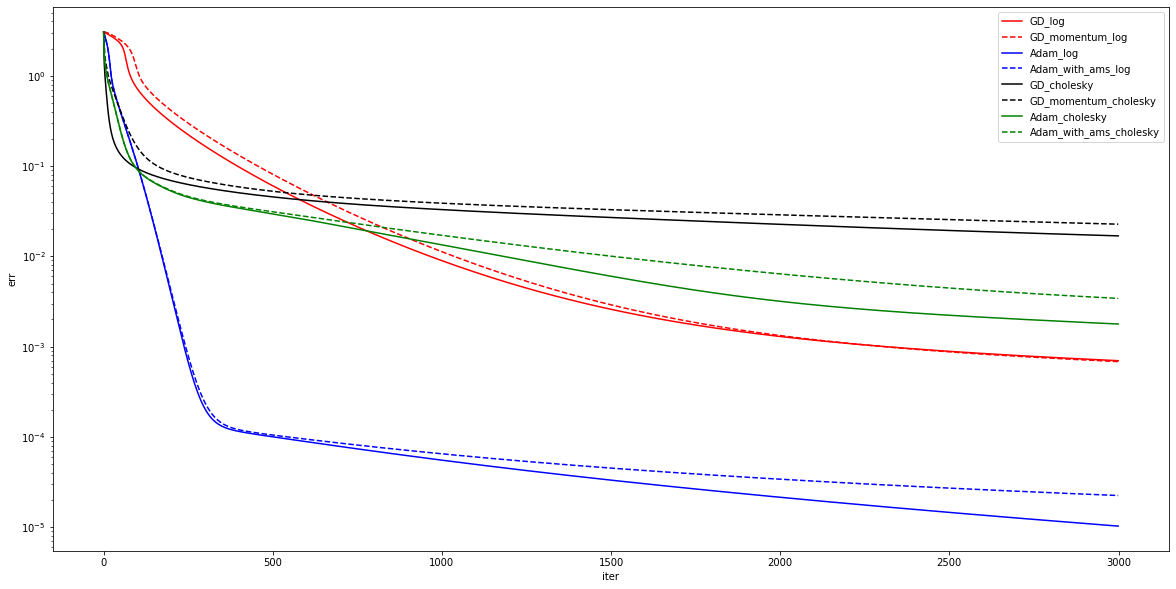

In [8]:
colors = ['r', 'r--', 'b', 'b--', 'k', 'k--', 'g', 'g--']
plt.figure(figsize=(20, 10))
for i, key in enumerate(opts.keys()):
    plt.plot(err_dict[key], colors[i])
plt.legend(opts.keys())
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')